#Init library

In [1]:
!pip install dgl

In [2]:
import dgl
import numpy as np
import pandas as pd


Using backend: pytorch


In [3]:
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py

#Load data

In [0]:
df3=pd.read_csv("https://raw.githubusercontent.com/covidsimteam/Contact-Tracing/master/dgl_map/estadoslatlon.csv")
df2=pd.read_csv('https://raw.githubusercontent.com/covidsimteam/Contact-Tracing/master/dgl_map/DensPob.csv')
estados_list=df3["Estado"].to_list()
lat_list=df3["Lat"]
lon_list=df3['Long']


##Visualise Data

In [0]:
# densidad=df2.sort_values(by=['Densidad'])
# fig = px.bar(densidad, y="Estado", x="Densidad", orientation='h',height=800,width=800,labels={'Densidad':'Population Density [inhabitants per square km]','Estado':'State'})
# fig.show()

#Prepare DGLGraph Graph

In [0]:
n_nodes =32

##Add nodes to graph

In [0]:
G=dgl.DGLGraph()
G.add_nodes(n_nodes)

##Add edges to graph

In [0]:
import numpy as np
def build_map():
  src=np.array([0 ,0 ,0,
                1 ,1 ,
                2 ,
                3 ,3 ,3 ,
                4 ,4 ,4 ,
                5 ,5 ,5 ,
                6 ,6 ,6 ,6 ,
                7 ,7 ,7 ,7 ,7 ,7 , 
                8 ,8 , 
                9 ,9 ,9 ,9 ,9 ,9 , 
                10 ,10 ,10 ,10 ,10 ,
                11 ,11 ,11 ,11 ,11 ,
                12 ,12 ,12 ,12 ,12 ,12 ,
                13 ,13 ,13 ,13 ,13 ,13 ,
                14  ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,
                15 , 15 ,15 ,15 ,15 ,15 ,
                16 ,16 ,16 ,16 ,
                17 ,17 ,17 , 
                18 ,18 ,18 ,
                19 ,19 ,19 ,19 ,
                20 ,20 ,20 ,20 ,20 ,20 ,20 , 
                21 ,21 ,21 ,21 ,21 ,
                22 ,22 ,
                23 ,23 ,23 ,23 ,23 ,23 ,
                24 ,24 ,24 ,24 ,
                25 ,25 ,25 ,
                26 ,26 ,26 ,
                27 ,27 ,27 ,
                28 ,28 ,28 ,
                29 ,29 ,29 ,29 ,29 ,29 ,
                30 ,30,
                31 ,31 ,31 ,31 ,31])
  dst=np.array([ 17, 31,5,
       8, 25,
       1,
       22, 26, 30,
       14, 16, 20,
       19, 26, 29,
       7, 9, 24, 25,
       6, 9, 31, 23, 18, 27,
       13, 15, 
       6, 7, 13, 17, 24, 31, 
       23, 31, 13, 15, 21,
       15, 14, 16, 20, 19, 
       29, 23, 21, 14, 28, 20,
       17, 31, 0, 10, 15, 8,
       21 , 10, 15, 11, 16, 4, 20, 28, 12,
       13,  8, 11, 14, 21, 10,
       11, 20, 4, 14,
       24, 9, 13, 
       7, 23, 27,
       11, 5, 29, 20,
       11, 19, 29, 12, 28, 14, 16, 
       23, 10, 15, 14, 12,
       3, 30,
       29, 27, 18, 31, 10, 21,
       25, 6, 9, 17,
       1, 6, 24,
       29, 5, 3,
       18, 23, 29,
       20, 14, 12,
       27, 23, 12, 20, 19, 26,
       3, 22,
       7, 9, 13, 0, 23])
  # u=np.concatenate([src])
  # v=np.concatenate([dst,src])
  return dgl.DGLGraph((src,dst))

In [0]:
G=build_map() #build graph , dgl
# print(G.number_of_nodes())
# print(G.number_of_edges())

##Adding Features to Graph

In [423]:
import torch
import torch.nn as nn
import torch.nn.functional as F


input_features=500 #assume we use these number of features
torch.manual_seed(5)
embed = nn.Embedding(n_nodes, input_features) 
inputs = embed.weight


print(embed.weight)


Parameter containing:
tensor([[ 1.8423,  0.5189, -1.7119,  ...,  0.6768, -0.3040,  2.1752],
        [ 0.1067,  0.4856, -2.6059,  ...,  0.8857, -0.7724,  1.1395],
        [-0.6645,  1.8356,  0.9183,  ...,  0.5341,  0.6400,  1.4115],
        ...,
        [ 0.7059,  1.2899, -0.5874,  ...,  0.4616, -0.6506,  0.1827],
        [-0.0164,  2.4935,  0.7795,  ..., -1.6841, -1.9925, -0.2720],
        [ 0.9576, -0.2557,  1.2807,  ...,  0.1961,  0.3670, -1.0563]],
       requires_grad=True)


In [0]:
x = torch.arange(0,n_nodes)
G.ndata['feat'] =torch.nn.functional.one_hot(x)
G.ndata['featm'] =torch.nn.functional.one_hot(x)
# G.ndata['k'] =torch.nn.functional.one_hot(x)

In [0]:
for i in range(n_nodes):
  G.ndata['feat'][i]=G.ndata['feat'][i]*df2['Densidad'][i]*2

#GraphConvolution

In [0]:
from dgl.nn.pytorch import GraphConv

##Define model with GraphConv Layer

In [0]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size, )
        self.conv2 = GraphConv(hidden_size, num_classes, )

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h


##Semi Supervised Data about known infection

In [0]:
nodes_infected =[3, 6, 0]
infection_severity = [4,0, 1]

labeled_nodes = torch.tensor(nodes_infected)   #node number
labels = torch.tensor(infection_severity)    #infectionLevel

max_severity = max(infection_severity)

In [429]:
print(G, embed.weight.size())

DGLGraph(num_nodes=32, num_edges=133,
         ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.int64), 'featm': Scheme(shape=(32,), dtype=torch.int64)}
         edata_schemes={}) torch.Size([32, 500])


In [430]:
import itertools

epoch_ = 50
hiddenLayer_1 =100

net = GCN(input_features, hiddenLayer_1, max_severity+1)



optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(epoch_):
    print([element.item() for element in inputs.flatten()][:5])
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

[1.8423298597335815, 0.5188871622085571, -1.7119213342666626, -1.7013792991638184, 2.0194194316864014]
Epoch 0 | Loss: 1.7633
[1.8323298692703247, 0.5288870930671692, -1.7219212055206299, -1.7113792896270752, 2.029419422149658]
Epoch 1 | Loss: 0.0766
[1.825248122215271, 0.5359485745429993, -1.7278755903244019, -1.7188693284988403, 2.0379514694213867]
Epoch 2 | Loss: 0.0065
[1.8198437690734863, 0.5413411259651184, -1.732407569885254, -1.7248154878616333, 2.0447418689727783]
Epoch 3 | Loss: 0.0007
[1.8154289722442627, 0.5457481741905212, -1.7361128330230713, -1.729703664779663, 2.0503251552581787]
Epoch 4 | Loss: 0.0001
[1.8116992712020874, 0.5494714975357056, -1.7392443418502808, -1.7338378429412842, 2.0550472736358643]
Epoch 5 | Loss: 0.0000
[1.8084850311279297, 0.5526801943778992, -1.7419430017471313, -1.7374013662338257, 2.059117555618286]
Epoch 6 | Loss: 0.0000
[1.805678129196167, 0.5554822683334351, -1.7442997694015503, -1.740513563156128, 2.0626723766326904]
Epoch 7 | Loss: 0.0000

In [0]:
import pandas as pd
df=pd.DataFrame(all_logits[epoch_-1][:].numpy())

In [0]:
lista=[]
for i in range(32):
  lista.append((all_logits[epoch_-1][i].numpy().argmax()))

df['li']=pd.Series(lista)

#Output Viz

## OPT- Convert DGI graph To Networkx Graph For Viz


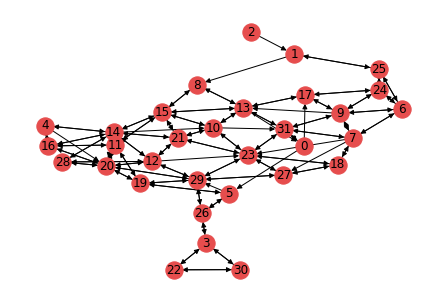

In [433]:
import networkx as nx
nx_G = G.to_networkx().to_directed()
pos = nx.kamada_kawai_layout(nx_G)

nx.draw(nx_G, pos, with_labels=True, node_color=[[.9, .3, .3]])

##PCA and GCN Output Viz

In [438]:
import matplotlib.animation as animation
from matplotlib import rc

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pcaall_logits = PCA(n_components=2)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

def draw(i):
    cls1color =['green', "#90EE90",'yellow', 'orange', 'red', ]
    pos = {}
    colors = []
    all_logitstemp = pcaall_logits.fit_transform(all_logits[i])
    for v in range(n_nodes):
        pos[v] = all_logitstemp[v]
        cls = all_logits[i][v].argmax()
        colors.append(cls1color[cls])
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G.to_networkx().to_directed(), pos, node_color=colors,
            with_labels=True, node_size=200, ax=ax)

fig, ax = plt.subplots()
plt.close()
# fig.clf()
# ax = fig.subplots()
# draw(2)  # draw the prediction of the first epoch

ani = animation.FuncAnimation(fig, draw, frames=50, interval=500)
rc('animation', html='jshtml')
# # ani.save('animation.mp4', writer=writer)
ani

#GeoMap

In [0]:
df['Lat']=lat_list
df['Long']=lon_list
df['Location']=estados_list

In [101]:
df

,0,1,2,3,4,li,Lat,Long,Location
0,1.913995,-1.389243,-1.488262,-1.943580,-0.704256,0,26.930560,88.093590,ILAM_MECHI
1,2.898085,-2.565353,-2.561409,-2.831952,0.297337,0,27.701671,83.465913,RUPANDEHI_LUMBINI
2,0.117727,-0.093321,-0.104989,-0.101314,0.079900,0,27.753100,85.327400,KATHMANDU_BAGMATI
3,0.593089,-12.024122,-9.706911,-10.704142,12.112634,4,28.754510,81.605620,DAILEKH_BHERI
4,4.137663,-2.435709,-2.537767,-2.623659,-0.835574,0,27.807100,82.625320,DANG_RAPTI
5,12.277205,-8.235226,-8.394670,-9.358977,-2.194816,0,27.698710,83.314770,RUPANDEHI_LUMBINI
6,5.652022,-5.176247,-5.097894,-6.075252,0.414266,0,27.822770,85.542270,SINDHUPALCHOK_BAGMATI
7,2.648849,-2.736190,-2.877272,-3.603128,0.346894,0,26.830283,87.287533,SUNSARI_KOSHI
8,1.025507,-2.880283,-2.258301,-3.566737,1.226082,4,27.687305,84.263723,NAWALPARASI_LUMBINI
9,3.581764,-4.526385,-4.369496,-5.412028,1.602925,0,26.596200,87.273580,SUNSARI_KOSHI


In [102]:
fig = px.scatter_geo(df, lat="Lat",lon="Long", color='li',size=df['li']+1,
                     #animation_frame="Fecha",
                     scope='asia',#range_color=[0,max(todos['conteo'])],
                     center={'lat':28.7,'lon':85.3},width=1200, height=1200,text = df['Location'],
                     projection="natural earth")


fig.show()